## Configuration

In [2]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = '/melanoma_distance_100_XX'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/melanoma_distance_100_XX'
motif_size = 5
iterations = 1000
force_run_fanmod = False
force_parse = False

In [3]:
cells_type = {
    0: 'B cell',
    1: 'CD4 APC',
    2: 'CD4 T cell',
    3: 'CD4 Treg',
    4: 'CD8 T cell',
    5: 'DCs',
    6: 'Germinal Center B cell',
    7: 'Hevs',
    8: 'MAC',
    9: 'Memory CD4 T Cell',
    10: 'NK cell',
    11: 'Neutrophil',
    12: 'Stroma',
    13: 'Tumor',
    14: 'Unidentified',
    15: 'Vessels'
}

Distant_metastases_class = {
    'NP': 'NP',
    'NN': 'NN',
    'PN': 'PN',
    'PP': 'PP',
}

class_to_color = {
    'NP': 'green',
    'NN': 'yellow',
    'PN': 'magenta',
    'PP': 'blue',
}

target_classes = ['NN', 'NP']
target_classes_str = 'NN_NP'

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [4]:
from cism.cism import CISM

In [5]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'Melanoma', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [6]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
                                                tissue_state_to_string=Distant_metastases_class,
                                                common_cells_type=cells_type)

In [7]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NN,20
NP,18
PN,13
PP,17


## Figure 2
Context-dependent identification of spatial motifs can predict the state of human melanoma disease

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


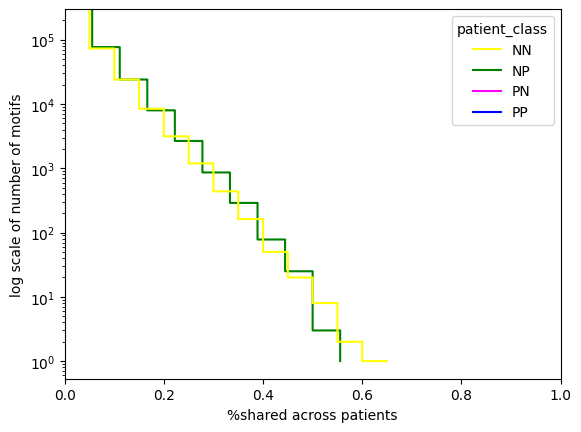

In [8]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=target_classes)

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [9]:
# export data to excel
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +'/number_of_motifs_versus_shared_percentage.csv')

### Performance Diagram
1. Pairwise Learning
2. 3 Nodes Motifs
3. 4 Nodes Motifs
4. 5 Nodes Motifs
5. Permutation tests (for threshold 0.46)
6. GNN Performance

Here we export the data for 1, 4, 5


#### Pairwise Learning

In [3]:
#read graphs
from pairwise.reader import GraphReader

full_graph_df = pd.DataFrame()
full_graph_df = GraphReader.get_graphs(full_graph_df=full_graph_df,
                                       raw_data_folder=raw_data_folder,
                                       raw_data_folder_type=raw_data_folder_dataset,
                                       disease='Melanoma',
                                       cells_type=cells_type)

In [4]:
from pairwise.pairwise_model import PairwiseAnalysis

pairwise_analysis = PairwiseAnalysis(
    tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class.csv',
    tissue_state_to_string=Distant_metastases_class)

In [10]:
cell_type_counts = pairwise_analysis.get_cell_type_count_from_classes(
                            full_graph_df=full_graph_df,
                            classes=['NN', 'NP','PN'],
                            cells_type=cells_type,
                            normalize=True)
cell_type_counts.to_csv(results_dir +'/NN_NP_PN_cell_type_frequency.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
group_a_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NN',
                                            cells_type=cells_type)
group_b_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NP',
                                            cells_type=cells_type)

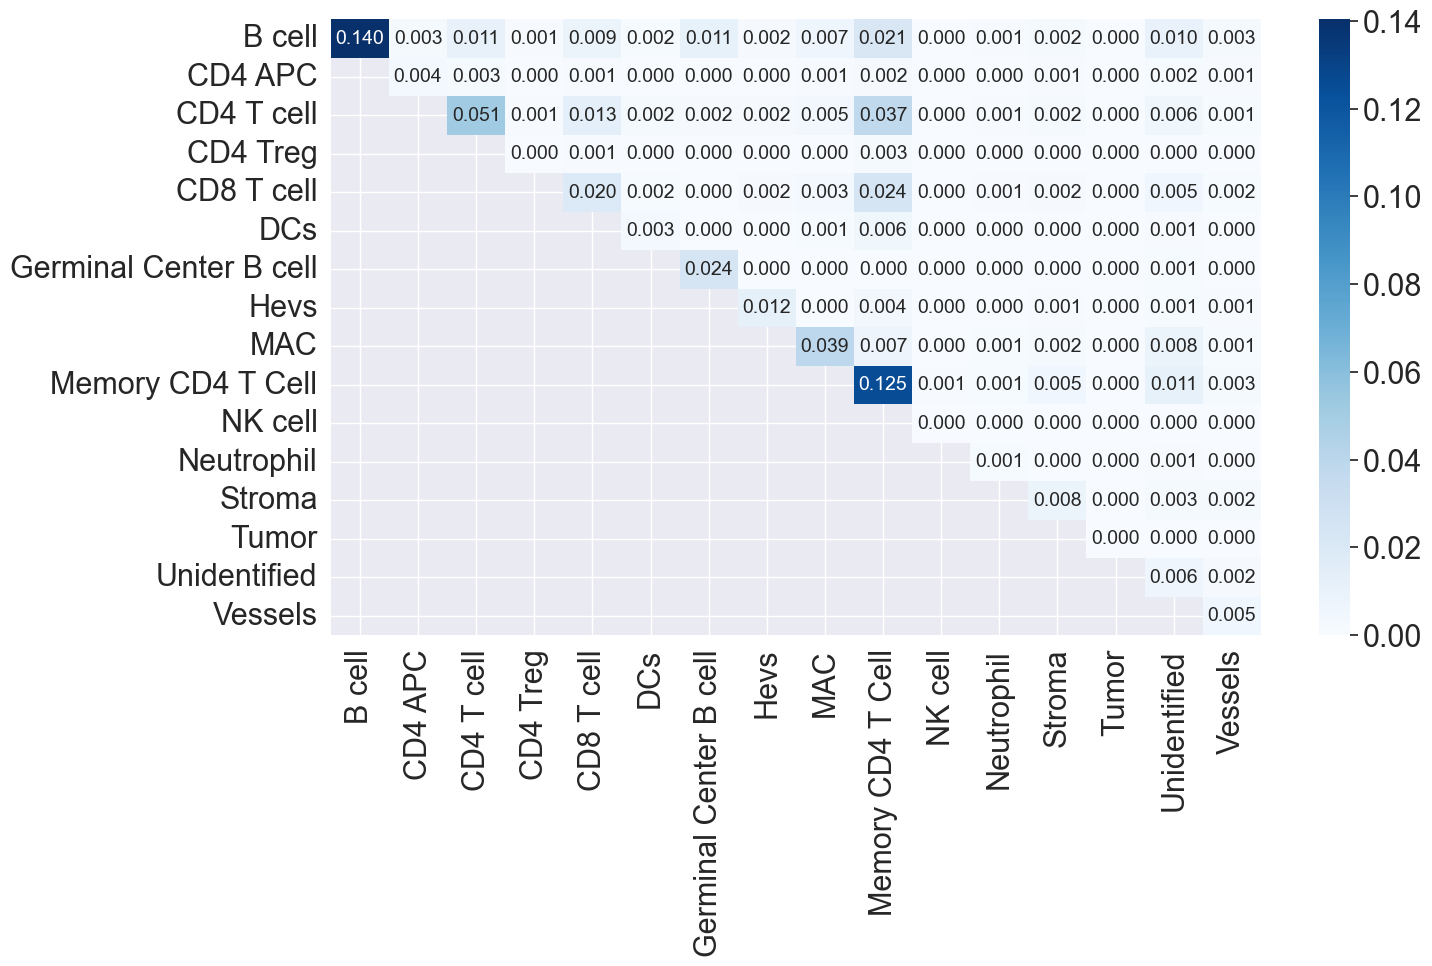

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))

sns.set(font_scale=2)

ax = sns.heatmap(group_a_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_a_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

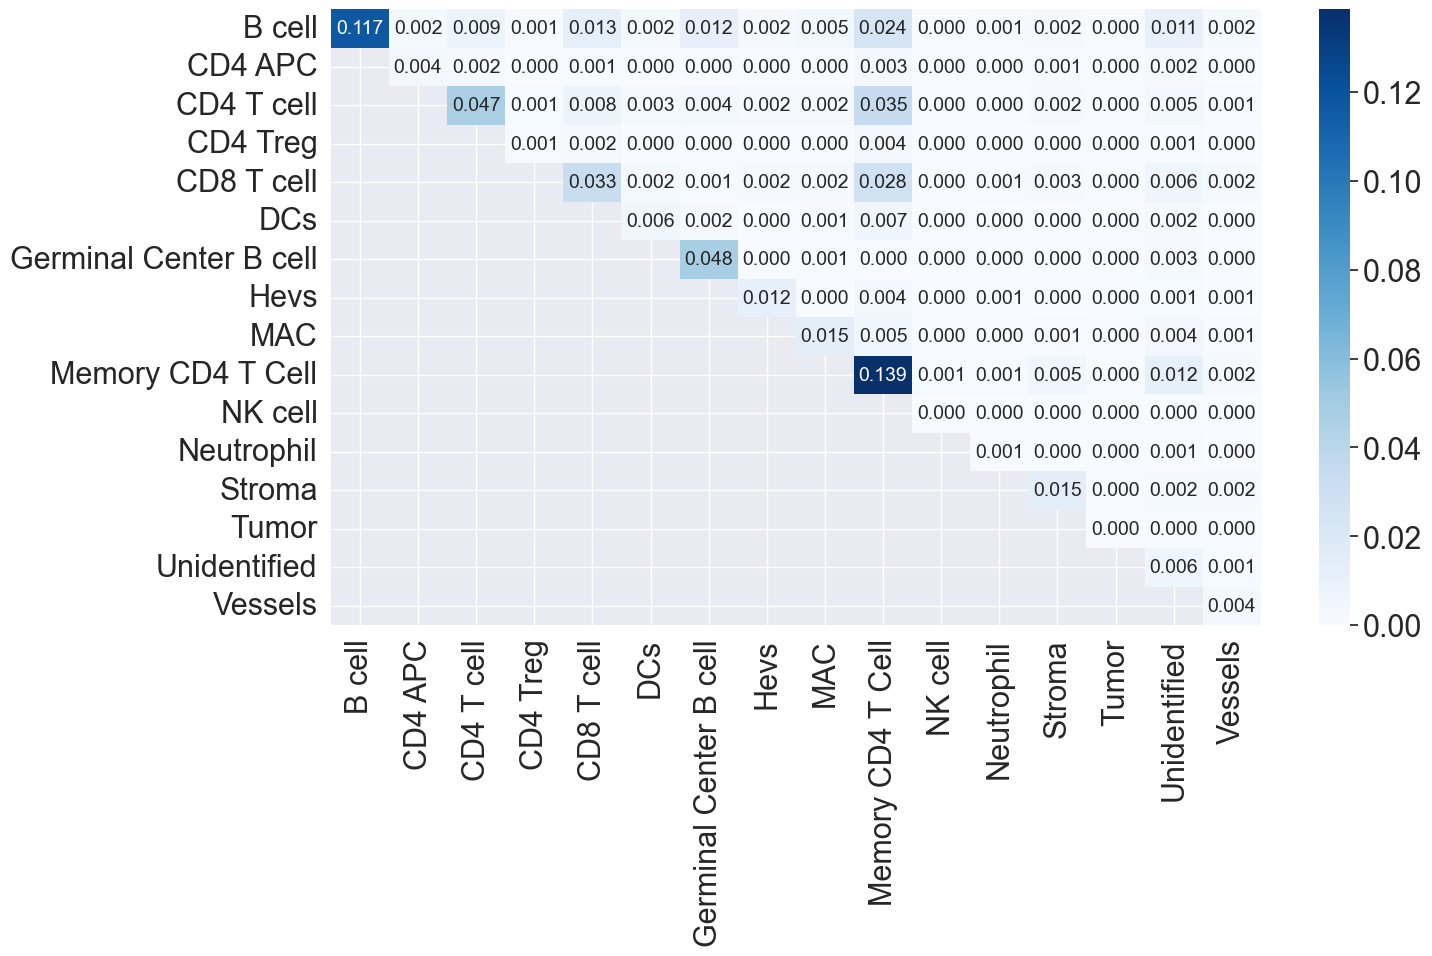

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

ax = sns.heatmap(group_b_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_b_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [9]:
import numpy as np

roc_auc_scores = pairwise_analysis.analyze(full_graph_df=full_graph_df,
                                           cells_type=cells_type,
                                           labels=['NN', 'NP'],
                                           trials=10)

print(f'roc_auc_score - mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]


KeyboardInterrupt



## 5 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [9]:
shared_percentage_th = 0.46
local_motif_size = 5

In [10]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=30,
                                   labels=target_classes)

motif_space_features = discriminator.get_features(feature_conf=featureConf,
                                                          exclude_patients=[],
                                                          n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


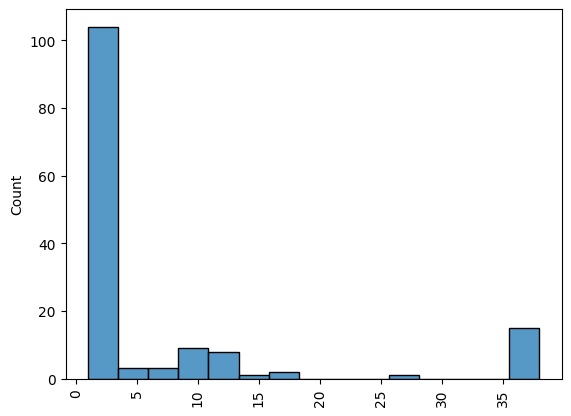

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [12]:
optimal_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [13]:
optimal_result.get_roc_auc_score()

0.7875

In [14]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 146, number of hashes: 117


{83642523355532: 6242340426492488716,
 313664966330764: 9061201570180626681,
 297163709293004: 7710208002406967212,
 288374060818892: 7710208002406967212,
 164136852344300: 4411254575308607775,
 128784842136012: 8566408388841294084,
 56377103098220: -5768768028389362545,
 81512291869036: 1068795552753912421,
 170719850128844: -862821480751832789,
 95950949705164: -2945146220698803705,
 205782822381004: -4782720867743686861,
 72869878326732: -6156726853842114698,
 6761510790604: 868163481621610569,
 154187587850732: -3473612204745480376,
 307081965430220: -7878447293172999338,
 124753174530508: -9032467371395819727,
 81530502457804: -2589755919613459239,
 292765666978252: 7710208002406967212,
 143238512323020: 1655833470991613645,
 81649806453196: -2945146220698803705,
 100135294314956: -5255296191909951618,
 85851342481868: -5067187399885985459,
 25434945432012: -5562288200077420028,
 95726530325964: -5255296191909951618,
 104739503500748: -1110891335820827131,
 95803841867212: -370135

In [15]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator.get_patients_class(target_classes)
for motif_id in all_motif_features:
    patients_ids = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID == motif_id) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == target_classes[0]:
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [16]:
print(f'group a: {len(group_a_motifs)}')
print(f'group b: {len(group_b_motifs)}')

group a: 90
group b: 56


In [27]:
discriminator.cism.motifs_dataset['Total'] = discriminator.cism.motifs_dataset['Count']/discriminator.cism.motifs_dataset['Freq']

In [36]:
new_freq_table = discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID'], observed=True)[['Count', 'Total']].sum().reset_index()

new_freq_table['Freq'] = new_freq_table['Count']/new_freq_table['Total']
motif_mean_count = new_freq_table.groupby('ID')['Freq'].mean()

In [39]:
import pandas as pd
import networkx as nx
import os
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list,
                                     motifs_weight: pd.DataFrame) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            from cism.helpers import string_base64_pickle
            target_motif = string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += motifs_weight.loc[motif_id]

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

motif_id: 313664966330764, hash_id: 9061201570180626681
motif_id: 283980287291788, hash_id: 9061201570180626681
motif_id: 297163709293004, hash_id: 7710208002406967212
motif_id: 288374060818892, hash_id: 7710208002406967212
motif_id: 292765666978252, hash_id: 7710208002406967212
motif_id: 294964694419916, hash_id: 7710208002406967212
motif_id: 286179332526540, hash_id: 7710208002406967212
motif_id: 315863981171148, hash_id: 7710208002406967212
motif_id: 164136852344300, hash_id: 4411254575308607775
motif_id: 56377103098220, hash_id: -5768768028389362545
motif_id: 81512291869036, hash_id: 1068795552753912421
motif_id: 170719850128844, hash_id: -862821480751832789
motif_id: 166319660310988, hash_id: -862821480751832789
motif_id: 95950949705164, hash_id: -2945146220698803705
motif_id: 81649806453196, hash_id: -2945146220698803705
motif_id: 89366771129804, hash_id: -2945146220698803705
motif_id: 72869878326732, hash_id: -6156726853842114698
motif_id: 154187587850732, hash_id: -347361220474

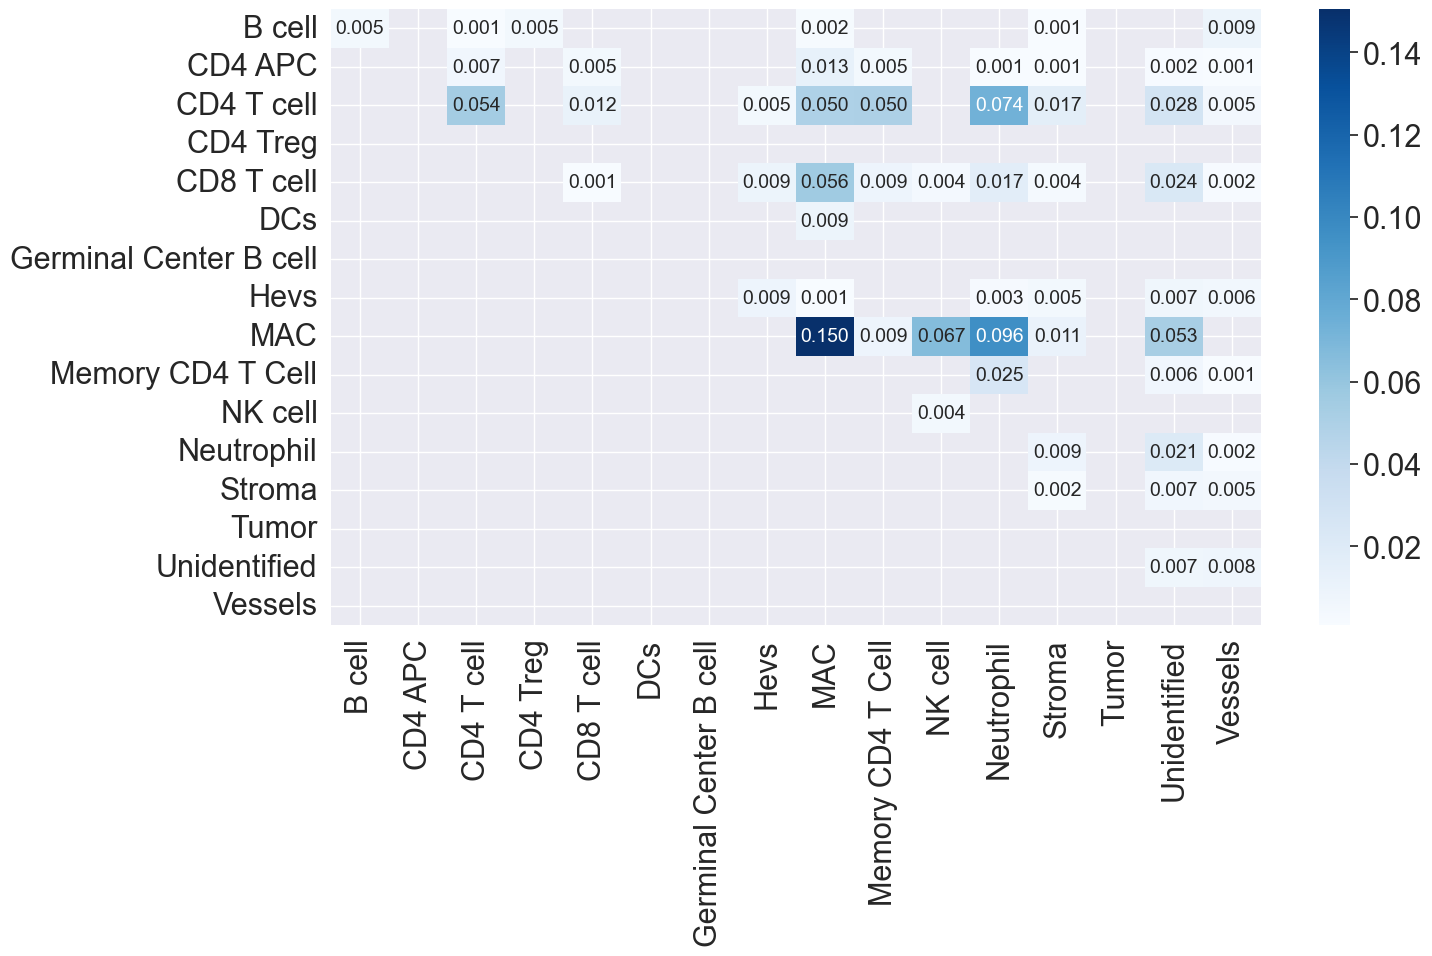

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
from cism import helpers

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(
                discriminator=discriminator,
                cells_type=cells_type,
                cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                motifs_ids=group_a_motifs,
                motifs_weight=motif_mean_count)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 83642523355532, hash_id: 6242340426492488716
motif_id: 128784842136012, hash_id: 8566408388841294084
motif_id: 205782822381004, hash_id: -4782720867743686861
motif_id: 6761510790604, hash_id: 868163481621610569
motif_id: 124753174530508, hash_id: -9032467371395819727
motif_id: 133524587236812, hash_id: -9032467371395819727
motif_id: 81530502457804, hash_id: -2589755919613459239
motif_id: 25434945432012, hash_id: -5562288200077420028
motif_id: 23274619867596, hash_id: -4765929989413547198
motif_id: 2402148364748, hash_id: -4765929989413547198
motif_id: 23270333286860, hash_id: -4765929989413547198
motif_id: 46469703053772, hash_id: -3386606129487089404
motif_id: 34091475349964, hash_id: 6915922370126081657
motif_id: 15413568315884, hash_id: 3088789774869567602
motif_id: 126547077015724, hash_id: 5221027578939539712
motif_id: 29865316432332, hash_id: -6189231459023983361
motif_id: 34233195307212, hash_id: -2957599920391936243
motif_id: 145304270803148, hash_id: 4700860425482556

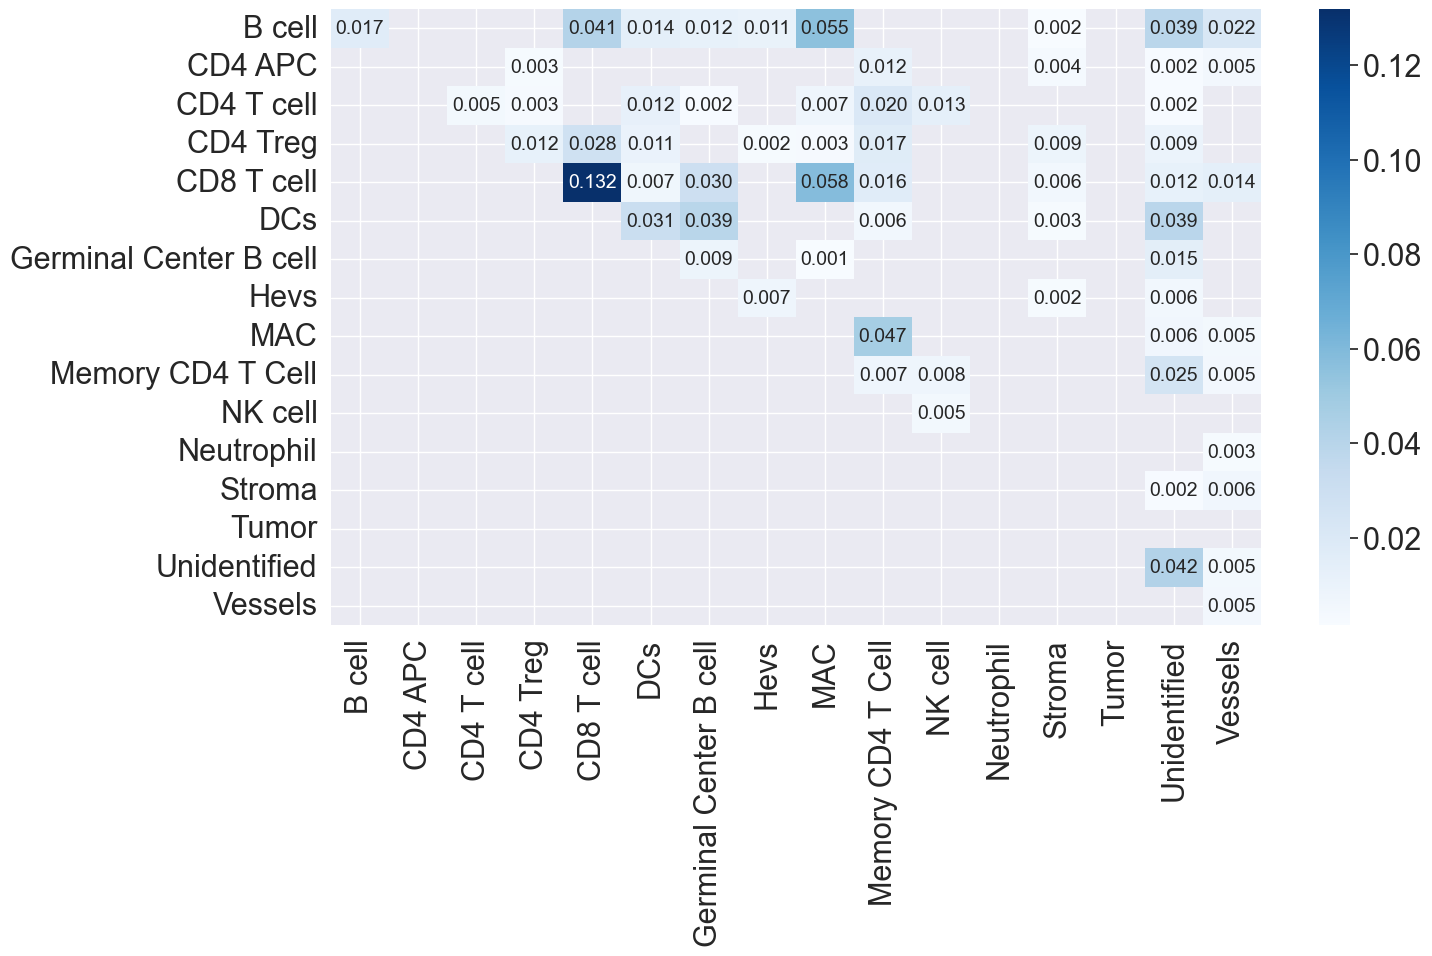

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(
            discriminator=discriminator,
            cells_type=cells_type,
            cell_identity_to_motif_hash=cell_identity_to_motif_hash,
            motifs_ids=group_b_motifs,
            motifs_weight=motif_mean_count)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [21]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(10):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=30,
        labels=target_classes,
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.5625


  0%|          | 0/38 [00:00<?, ?it/s]

0.5833333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

0.6319444444444444


  0%|          | 0/38 [00:00<?, ?it/s]

0.6083333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

0.5833333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

0.55


  0%|          | 0/38 [00:00<?, ?it/s]

0.5833333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

0.6194444444444445


  0%|          | 0/38 [00:00<?, ?it/s]

0.5861111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

0.6000000000000001


0.5908333333333333

In [45]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=30,
            labels=target_classes,
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6242340426492488716, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 9061201570180626681, roc_auc_score: 0.6277777777777778, roc_auc_ratio: 1.2544247787610618, avg features: 24.57894736842105, std features: 2.5535516225537602, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7710208002406967212, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.68421052631579, std features: 2.6108429120185597, number of mapped features: 6


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4411254575308607775, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8566408388841294084, roc_auc_score: 0.6444444444444444, roc_auc_ratio: 1.2219827586206897, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5768768028389362545, roc_auc_score: 0.6555555555555556, roc_auc_ratio: 1.201271186440678, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1068795552753912421, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -862821480751832789, roc_auc_score: 0.6625000000000001, roc_auc_ratio: 1.1886792452830186, avg features: 24.57894736842105, std features: 2.5322949632574074, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2945146220698803705, roc_auc_score: 0.6541666666666666, roc_auc_ratio: 1.2038216560509556, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 3


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -4782720867743686861, roc_auc_score: 0.6444444444444445, roc_auc_ratio: 1.2219827586206895, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -6156726853842114698, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 868163481621610569, roc_auc_score: 0.6611111111111112, roc_auc_ratio: 1.191176470588235, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3473612204745480376, roc_auc_score: 0.6375, roc_auc_ratio: 1.2352941176470589, avg features: 24.605263157894736, std features: 2.499075220137095, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7878447293172999338, roc_auc_score: 0.6499999999999999, roc_auc_ratio: 1.2115384615384617, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -9032467371395819727, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.57894736842105, std features: 2.500071122743645, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2589755919613459239, roc_auc_score: 0.6472222222222223, roc_auc_ratio: 1.2167381974248925, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1655833470991613645, roc_auc_score: 0.6875, roc_auc_ratio: 1.1454545454545455, avg features: 24.842105263157894, std features: 2.3310630423776866, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5255296191909951618, roc_auc_score: 0.6208333333333333, roc_auc_ratio: 1.268456375838926, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 4


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5067187399885985459, roc_auc_score: 0.6625, roc_auc_ratio: 1.1886792452830188, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5562288200077420028, roc_auc_score: 0.6680555555555556, roc_auc_ratio: 1.1787941787941787, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1110891335820827131, roc_auc_score: 0.6611111111111111, roc_auc_ratio: 1.1911764705882353, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3701350271973386723, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2496796446790714771, roc_auc_score: 0.6527777777777778, roc_auc_ratio: 1.2063829787234042, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -4765929989413547198, roc_auc_score: 0.6430555555555556, roc_auc_ratio: 1.2246220302375808, avg features: 24.57894736842105, std features: 2.500071122743645, number of mapped features: 3


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4845996942568793622, roc_auc_score: 0.6208333333333333, roc_auc_ratio: 1.268456375838926, avg features: 24.736842105263158, std features: 2.4680029187235335, number of mapped features: 3


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1574835941556850945, roc_auc_score: 0.6777777777777777, roc_auc_ratio: 1.1618852459016396, avg features: 24.57894736842105, std features: 2.532294963257407, number of mapped features: 3


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3386606129487089404, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6915922370126081657, roc_auc_score: 0.6611111111111111, roc_auc_ratio: 1.1911764705882353, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3910524127128593142, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.605263157894736, std features: 2.56314285209147, number of mapped features: 4


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1800524053526604920, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3088789774869567602, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5221027578939539712, roc_auc_score: 0.6444444444444444, roc_auc_ratio: 1.2219827586206897, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5059661957558818140, roc_auc_score: 0.6458333333333333, roc_auc_ratio: 1.2193548387096775, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -6189231459023983361, roc_auc_score: 0.6708333333333333, roc_auc_ratio: 1.173913043478261, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2957599920391936243, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4700860425482556942, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8559598499456462798, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5126162195708151315, roc_auc_score: 0.6499999999999999, roc_auc_ratio: 1.2115384615384617, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5952157261948394113, roc_auc_score: 0.6527777777777778, roc_auc_ratio: 1.2063829787234042, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8021388725285025965, roc_auc_score: 0.6611111111111111, roc_auc_ratio: 1.1911764705882353, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 7496292477314655027, roc_auc_score: 0.6611111111111112, roc_auc_ratio: 1.191176470588235, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1119830660563827886, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -6873248133125190918, roc_auc_score: 0.6458333333333333, roc_auc_ratio: 1.2193548387096775, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1071477583974413911, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8752707455194117191, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3485010214357869315, roc_auc_score: 0.6416666666666667, roc_auc_ratio: 1.227272727272727, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8028902590121996477, roc_auc_score: 0.6666666666666666, roc_auc_ratio: 1.1812500000000001, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1252608452026777637, roc_auc_score: 0.6458333333333333, roc_auc_ratio: 1.2193548387096775, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5342736358863059858, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1088574536318650481, roc_auc_score: 0.6375, roc_auc_ratio: 1.2352941176470589, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7569034503260920782, roc_auc_score: 0.6499999999999999, roc_auc_ratio: 1.2115384615384617, avg features: 24.57894736842105, std features: 2.5535516225537602, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2553229803515854445, roc_auc_score: 0.6527777777777778, roc_auc_ratio: 1.2063829787234042, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3250292950300132404, roc_auc_score: 0.6416666666666666, roc_auc_ratio: 1.2272727272727273, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3015803446918437573, roc_auc_score: 0.6611111111111111, roc_auc_ratio: 1.1911764705882353, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4348235273040888354, roc_auc_score: 0.6402777777777778, roc_auc_ratio: 1.229934924078091, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5508775688496190919, roc_auc_score: 0.7861111111111112, roc_auc_ratio: 1.0017667844522966, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2776294210873554673, roc_auc_score: 0.6305555555555555, roc_auc_ratio: 1.248898678414097, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2011054886902530099, roc_auc_score: 0.6277777777777778, roc_auc_ratio: 1.2544247787610618, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4214994853551186860, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1503862818429589398, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6642548001241677777, roc_auc_score: 0.6583333333333333, roc_auc_ratio: 1.1962025316455696, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8686985172060788063, roc_auc_score: 0.6555555555555556, roc_auc_ratio: 1.201271186440678, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8709269075758166144, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6996726187468554091, roc_auc_score: 0.6416666666666667, roc_auc_ratio: 1.227272727272727, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8018371728128202978, roc_auc_score: 0.6444444444444445, roc_auc_ratio: 1.2219827586206895, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3203410002681862038, roc_auc_score: 0.6763888888888889, roc_auc_ratio: 1.164271047227926, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8819034587700107762, roc_auc_score: 0.7222222222222222, roc_auc_ratio: 1.0903846153846153, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8087866632219751125, roc_auc_score: 0.7861111111111111, roc_auc_ratio: 1.0017667844522968, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7155229748679312318, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2932817744884171900, roc_auc_score: 0.6819444444444445, roc_auc_ratio: 1.154786150712831, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -4064757954001846825, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8446399016149160931, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8533268510779066726, roc_auc_score: 0.6138888888888889, roc_auc_ratio: 1.2828054298642533, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 4754143838390718330, roc_auc_score: 0.6444444444444445, roc_auc_ratio: 1.2219827586206895, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8944012667346942336, roc_auc_score: 0.6472222222222223, roc_auc_ratio: 1.2167381974248925, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8167364604624231865, roc_auc_score: 0.6763888888888888, roc_auc_ratio: 1.164271047227926, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1041562609856148337, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -6840435967436473791, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5063344096490503463, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -6262594440945891760, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -4691067942613432972, roc_auc_score: 0.6666666666666667, roc_auc_ratio: 1.18125, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3173522512318909202, roc_auc_score: 0.6458333333333333, roc_auc_ratio: 1.2193548387096775, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -915943079017516251, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2272383256673869148, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5677503428178240604, roc_auc_score: 0.7111111111111111, roc_auc_ratio: 1.107421875, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5618589445941143187, roc_auc_score: 0.6111111111111112, roc_auc_ratio: 1.2886363636363636, avg features: 24.57894736842105, std features: 2.5429455037402766, number of mapped features: 2


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 9191829507215430832, roc_auc_score: 0.6805555555555556, roc_auc_ratio: 1.157142857142857, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7637955549154867412, roc_auc_score: 0.6583333333333333, roc_auc_ratio: 1.1962025316455696, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 9148060602621421497, roc_auc_score: 0.6569444444444444, roc_auc_ratio: 1.1987315010570825, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8126917492156415797, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5743513802466900144, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3803477034675290904, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -562326984567277479, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -861734741266960324, roc_auc_score: 0.6861111111111111, roc_auc_ratio: 1.1477732793522266, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7080770408681914762, roc_auc_score: 0.6472222222222223, roc_auc_ratio: 1.2167381974248925, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2707055278498778236, roc_auc_score: 0.6611111111111111, roc_auc_ratio: 1.1911764705882353, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8717745087687995579, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -5440228772225441584, roc_auc_score: 0.6708333333333334, roc_auc_ratio: 1.1739130434782608, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2254343751780590317, roc_auc_score: 0.6722222222222223, roc_auc_ratio: 1.171487603305785, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7412552327596350023, roc_auc_score: 0.6625000000000001, roc_auc_ratio: 1.1886792452830186, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -1837511654893859304, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7164396600414986424, roc_auc_score: 0.7958333333333333, roc_auc_ratio: 0.9895287958115183, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6407870885082193312, roc_auc_score: 0.6638888888888889, roc_auc_ratio: 1.1861924686192469, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -4704671565739628939, roc_auc_score: 0.6416666666666666, roc_auc_ratio: 1.2272727272727273, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5024859603902834109, roc_auc_score: 0.6361111111111111, roc_auc_ratio: 1.237991266375546, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -8526583705672692446, roc_auc_score: 0.6666666666666667, roc_auc_ratio: 1.18125, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5403786738322586439, roc_auc_score: 0.6736111111111112, roc_auc_ratio: 1.1690721649484535, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6296451095125424006, roc_auc_score: 0.6277777777777778, roc_auc_ratio: 1.2544247787610618, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6255620444277460015, roc_auc_score: 0.6597222222222222, roc_auc_ratio: 1.1936842105263157, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -7075560937886522940, roc_auc_score: 0.6555555555555556, roc_auc_ratio: 1.201271186440678, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2348168526511135323, roc_auc_score: 0.6888888888888889, roc_auc_ratio: 1.1431451612903225, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 1291034585276831462, roc_auc_score: 0.7930555555555555, roc_auc_ratio: 0.9929947460595446, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 5535536565266385038, roc_auc_score: 0.701388888888889, roc_auc_ratio: 1.1227722772277227, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -675278960118045004, roc_auc_score: 0.6777777777777778, roc_auc_ratio: 1.1618852459016393, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 2895432794365534219, roc_auc_score: 0.6527777777777778, roc_auc_ratio: 1.2063829787234042, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2612401262723880226, roc_auc_score: 0.6541666666666667, roc_auc_ratio: 1.2038216560509554, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 8118758303747252439, roc_auc_score: 0.6694444444444445, roc_auc_ratio: 1.1763485477178421, avg features: 24.55263157894737, std features: 2.5115664157249435, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,6242340426492488716,0.654167,0.0,[0.6541666666666667],1.203822,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,9061201570180626681,0.627778,0.0,[0.6277777777777778],1.254425,24.578947,2.553552,2.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,7710208002406967212,0.663889,0.0,[0.6638888888888889],1.186192,24.684211,2.610843,6.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,4411254575308607775,0.656944,0.0,[0.6569444444444444],1.198732,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,8566408388841294084,0.644444,0.0,[0.6444444444444444],1.221983,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
...,...,...,...,...,...,...,...,...,...
112,5535536565266385038,0.701389,0.0,[0.701388888888889],1.122772,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
113,-675278960118045004,0.677778,0.0,[0.6777777777777778],1.161885,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
114,2895432794365534219,0.652778,0.0,[0.6527777777777778],1.206383,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
115,-2612401262723880226,0.654167,0.0,[0.6541666666666667],1.203822,24.552632,2.511566,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [ ]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

In [ ]:
from cism.vis.draw import plot_colors_bar

plot_colors_bar(discriminator, ratio_gain_results, cells_type)

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))
g = sns.barplot(ratio_gain_results, x='hash', y='roc_auc_score', order=ratio_gain_results['hash'])
plt.xticks(rotation=90)
g.axhline(np.mean(switch_all_roc_auc_scores), ls='--', color='orange', ms='50')

In [ ]:
ratio_gain_results.to_csv(results_dir +'/' + f'ratio_gain_{target_classes_str}_{local_motif_size}_results.csv' )

In [20]:
discriminator.cism.motifs_dataset[
        (discriminator.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=True)['Count'].sum().reset_index().to_csv(results_dir +'/' + f'{target_classes_str}_{local_motif_size}_motifs_counts_across_patients.csv')

motif_id: 156288629874988, hash_id: -5508775688496190919


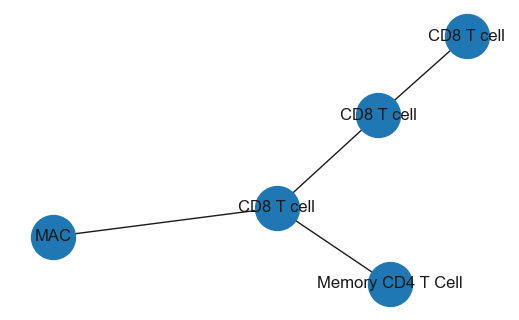

motif_id: 2225877395948, hash_id: -2348168526511135323


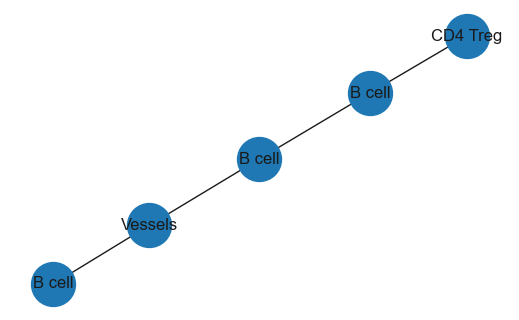

motif_id: 4711994875372, hash_id: 5535536565266385038


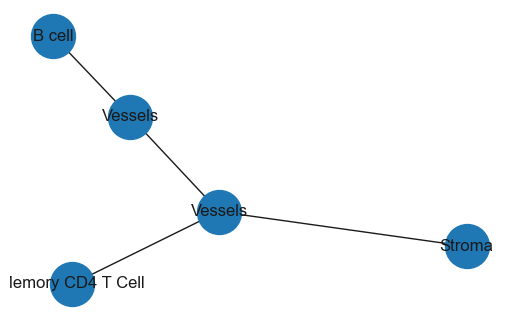

motif_id: 143238512323020, hash_id: 1655833470991613645


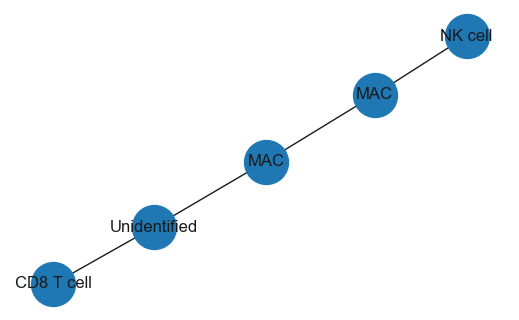

motif_id: 75098901254476, hash_id: 8087866632219751125


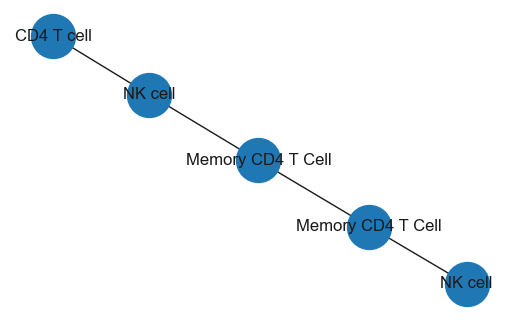

motif_id: 294955048536524, hash_id: 2932817744884171900


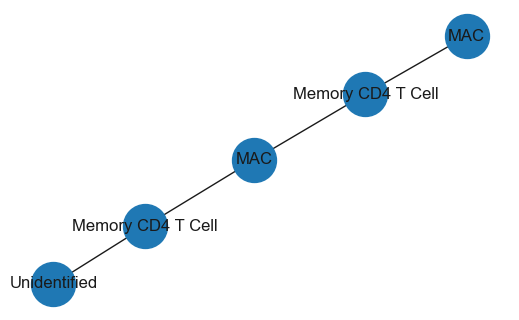

motif_id: 145304270803148, hash_id: 4700860425482556942


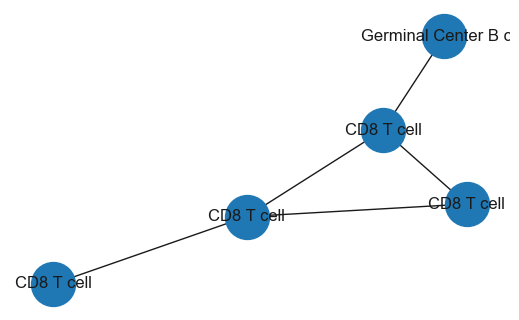

motif_id: 6860375881100, hash_id: -5677503428178240604


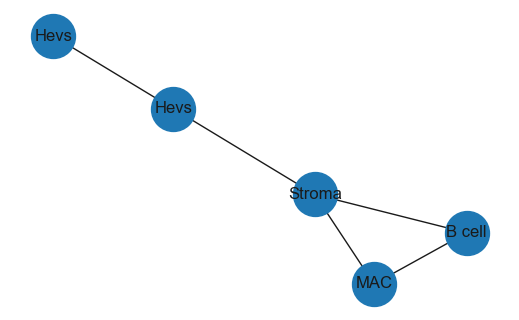

motif_id: 91534620126572, hash_id: 4845996942568793622


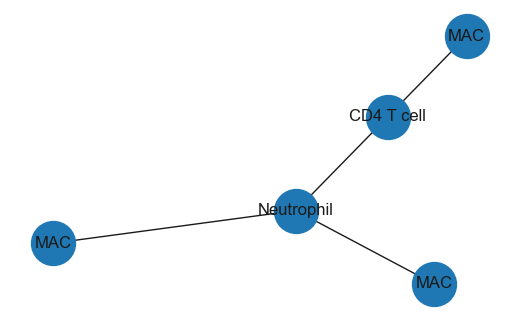

motif_id: 91534637952364, hash_id: 4845996942568793622


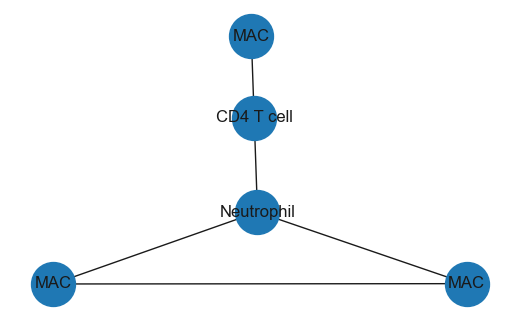

motif_id: 102343773635980, hash_id: -5618589445941143187


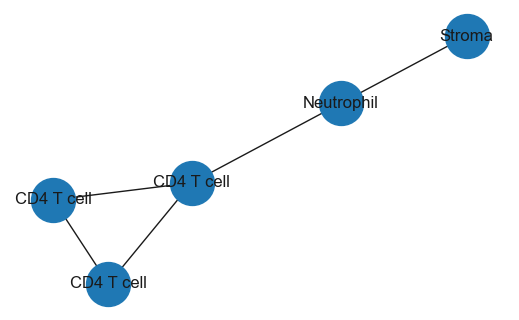

motif_id: 81453056814444, hash_id: -1574835941556850945


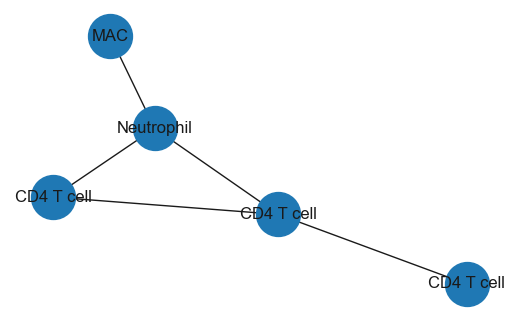

motif_id: 102352365569388, hash_id: -1574835941556850945


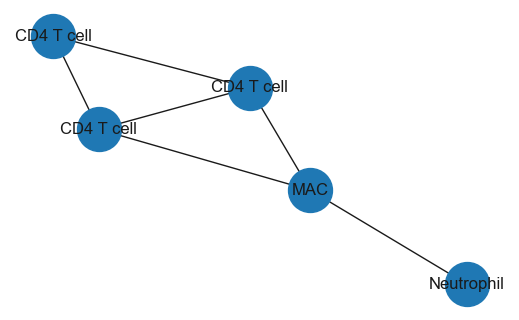

motif_id: 48526971373836, hash_id: -5342736358863059858


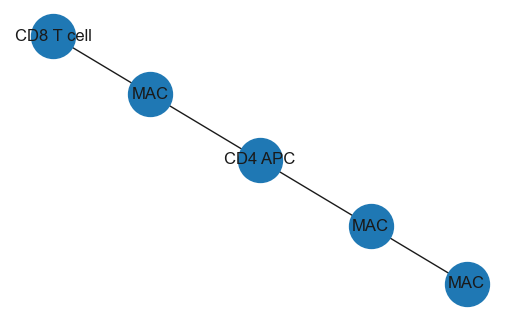

motif_id: 205782822381004, hash_id: -4782720867743686861


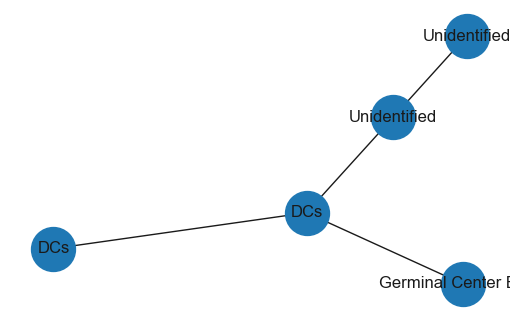

motif_id: 60584957880620, hash_id: -2776294210873554673


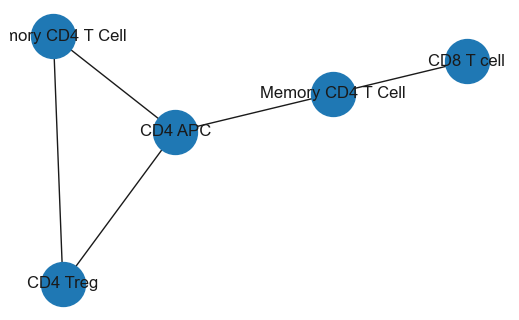

motif_id: 170719850030444, hash_id: -3910524127128593142


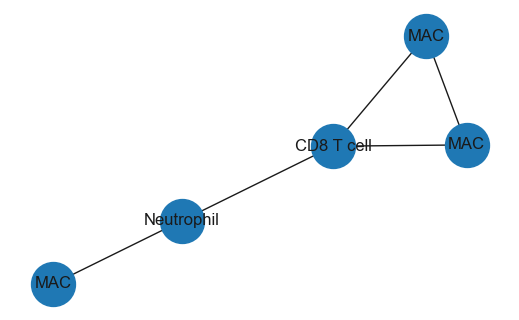

motif_id: 74840095872364, hash_id: 1041562609856148337


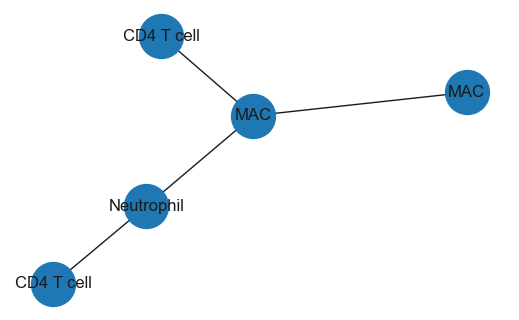

motif_id: 143100939086316, hash_id: 1071477583974413911


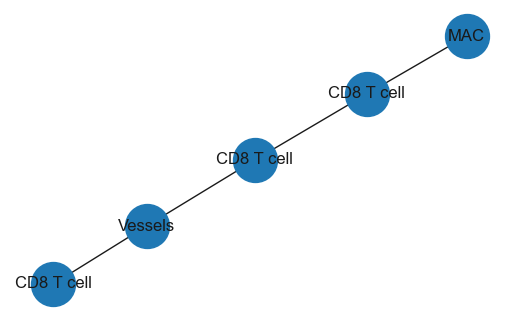

motif_id: 164102409604460, hash_id: -6840435967436473791


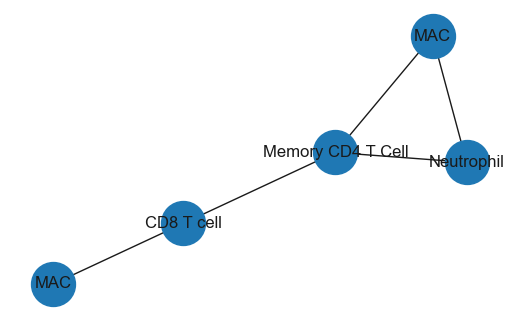

motif_id: 311457338451276, hash_id: -4064757954001846825


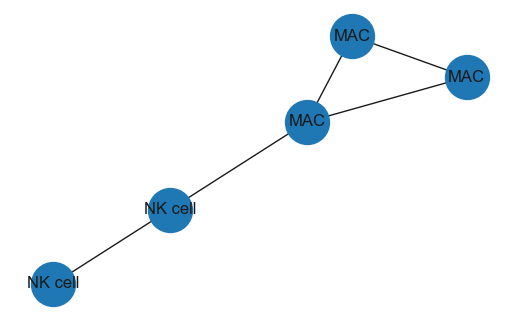

motif_id: 208008661648844, hash_id: 4348235273040888354


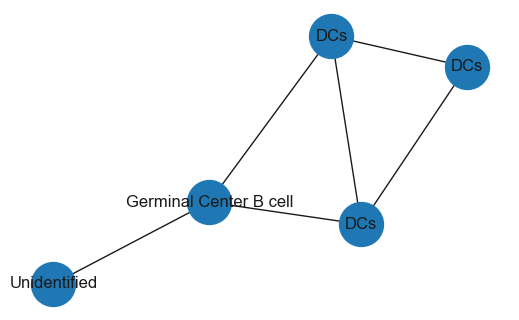

motif_id: 91332572970348, hash_id: 8028902590121996477


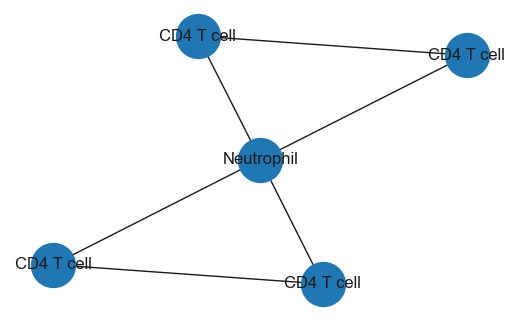

motif_id: 85851342481868, hash_id: -5067187399885985459


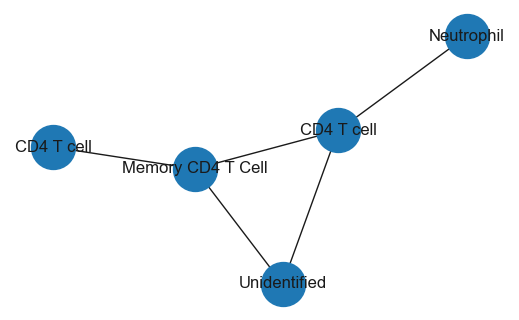

motif_id: 93751901260172, hash_id: -2272383256673869148


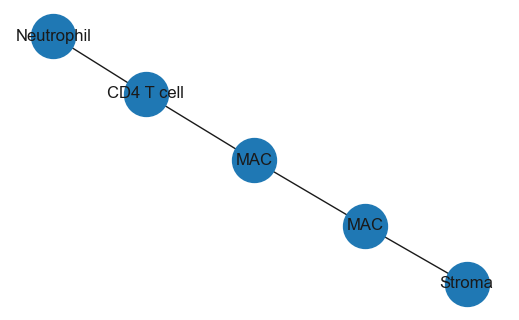

motif_id: 297163709293004, hash_id: 7710208002406967212


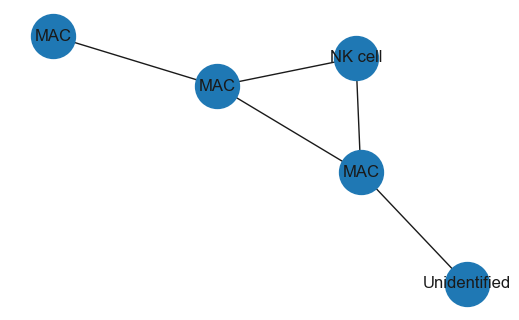

motif_id: 286179332526540, hash_id: 7710208002406967212


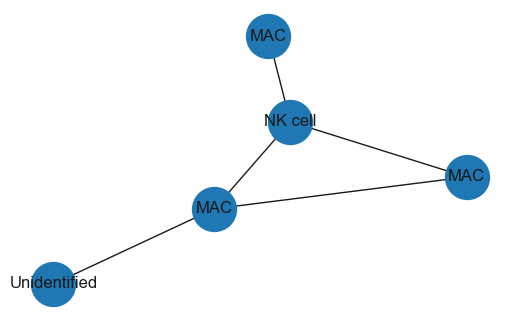

motif_id: 288374060818892, hash_id: 7710208002406967212


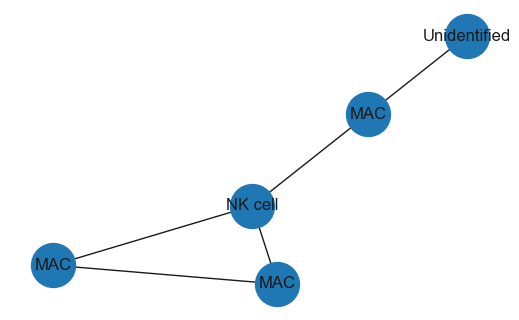

motif_id: 315863981171148, hash_id: 7710208002406967212


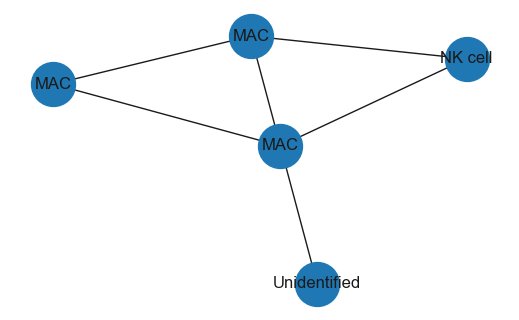

motif_id: 166319660310988, hash_id: -862821480751832789


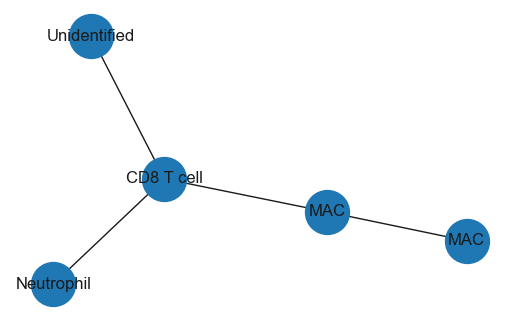

motif_id: 168456335349196, hash_id: -7080770408681914762


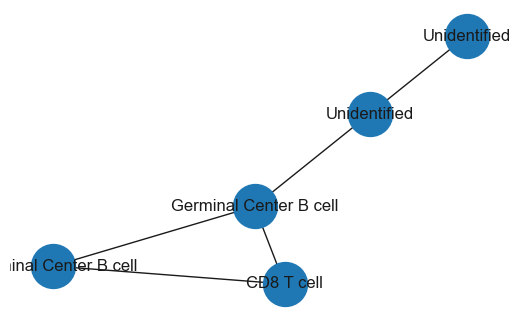

motif_id: 95730807388524, hash_id: -6873248133125190918


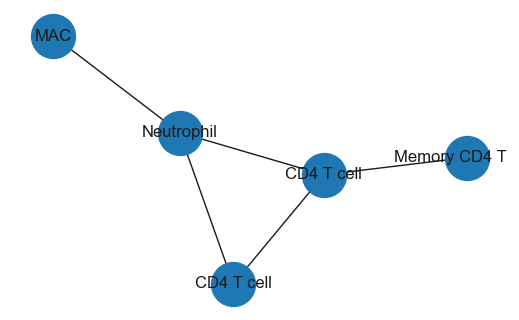

motif_id: 128750391005580, hash_id: -7637955549154867412


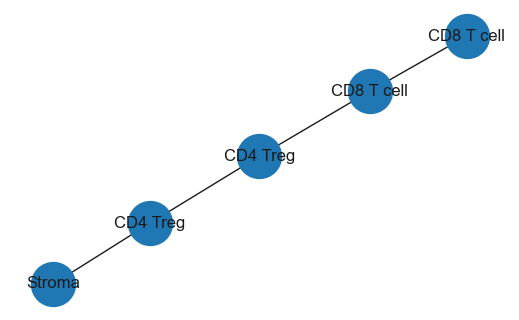

motif_id: 23364954950092, hash_id: 8819034587700107762


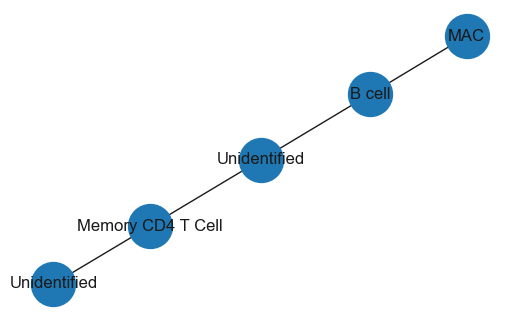

motif_id: 25434945432012, hash_id: -5562288200077420028


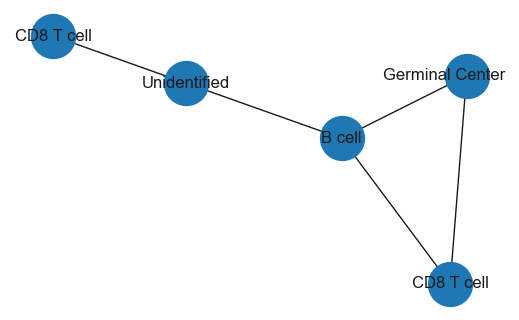

motif_id: 48458117712332, hash_id: 8533268510779066726


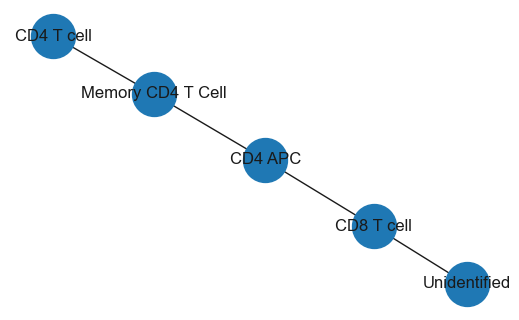

motif_id: 6619622781196, hash_id: -1088574536318650481


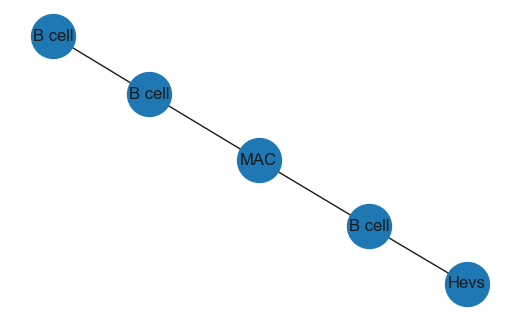

motif_id: 89220724300140, hash_id: 5403786738322586439


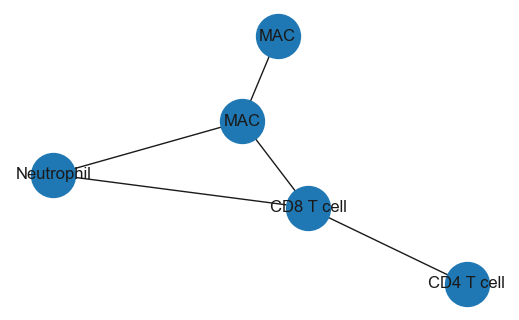

motif_id: 83844518943084, hash_id: -8526583705672692446


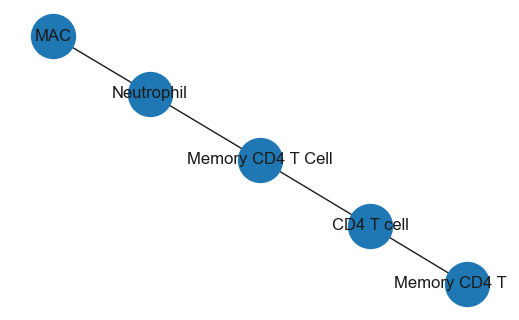

motif_id: 8983422655948, hash_id: 3173522512318909202


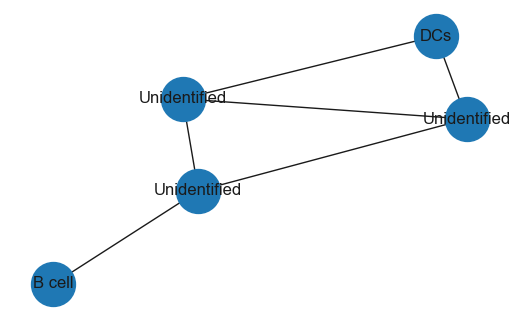

motif_id: 81439324730700, hash_id: 8944012667346942336


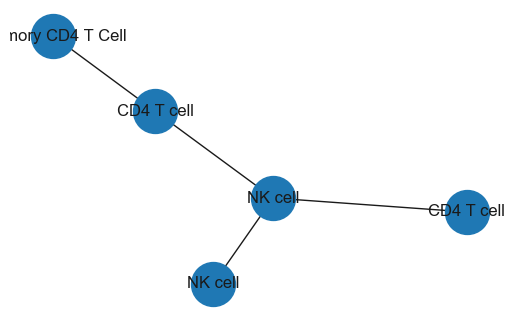

motif_id: 21028320454924, hash_id: -3015803446918437573


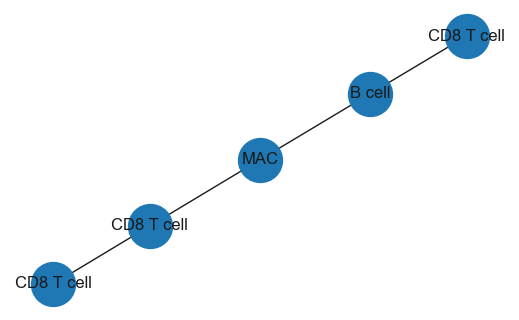

motif_id: 172866290321676, hash_id: 3250292950300132404


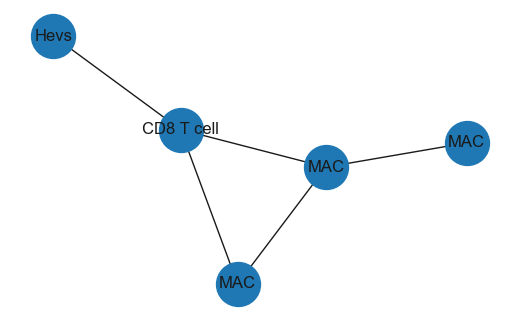

motif_id: 79244591222220, hash_id: -5255296191909951618


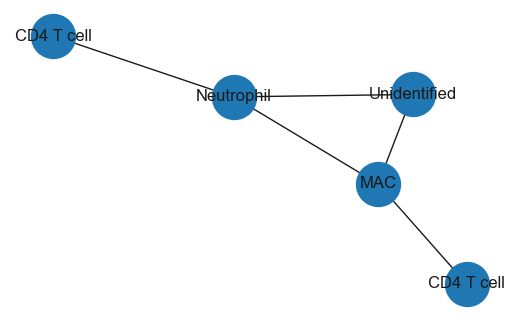

motif_id: 81649806453196, hash_id: -2945146220698803705


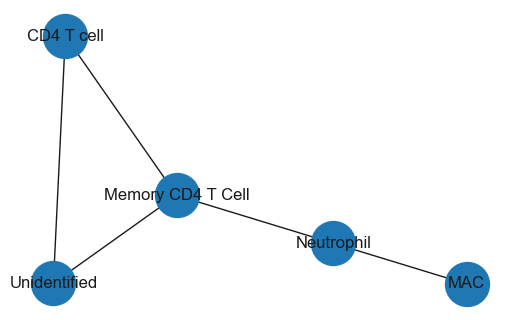

motif_id: 34233195307212, hash_id: -2957599920391936243


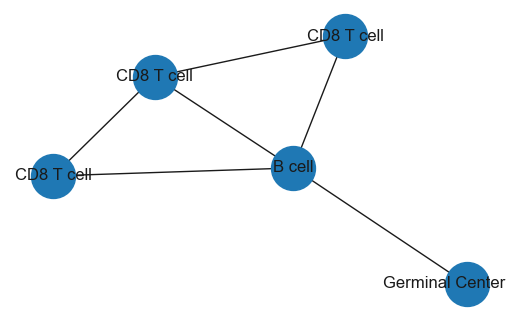

motif_id: 286156783895916, hash_id: -6262594440945891760


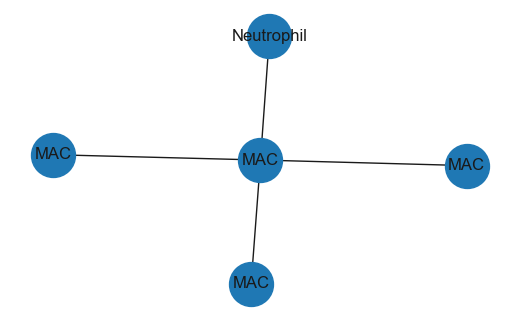

motif_id: 77065754049900, hash_id: 1252608452026777637


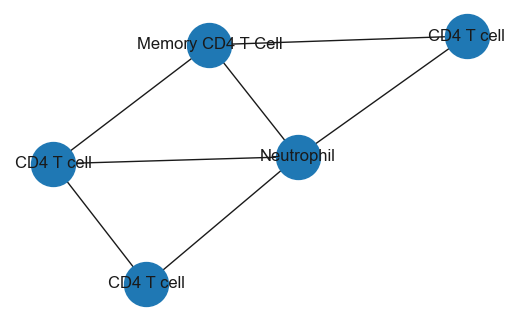

In [26]:
from cism.vis import draw

for idx, row in ratio_gain_results.iterrows():
    hash_id = ratio_gain_results.loc[idx].hash
    motifs = cell_identity_to_motif_hash[ratio_gain_results.loc[idx].hash]
    for motif_id in motifs:
        print(f'motif_id: {motif_id}, hash_id: {hash_id}')
        target_motif = cism.motifs_dataset[cism.motifs_dataset.ID == motif_id].iloc[0].motif
        target_motif = helpers.string_base64_pickle(target_motif)
        draw.draw_motif(target_motif, cells_type=cells_type)